# Выбор и обучение модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style()

In [2]:
from sklearn.model_selection import train_test_split

features = pd.read_csv('data/processed/train.csv')
labels = pd.read_csv('data/processed/labels.csv')

X = features.drop('ad_id', axis=1)
y = labels['at_least_one']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Выбор признаков

Посмотрим вообще на то, как выглядят наши признаки:

In [3]:
def draw_corr_matrix(df: pd.DataFrame, size: float = 20):
    corr_matrix = df.corr()
    plt.figure(figsize=(size,size))
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

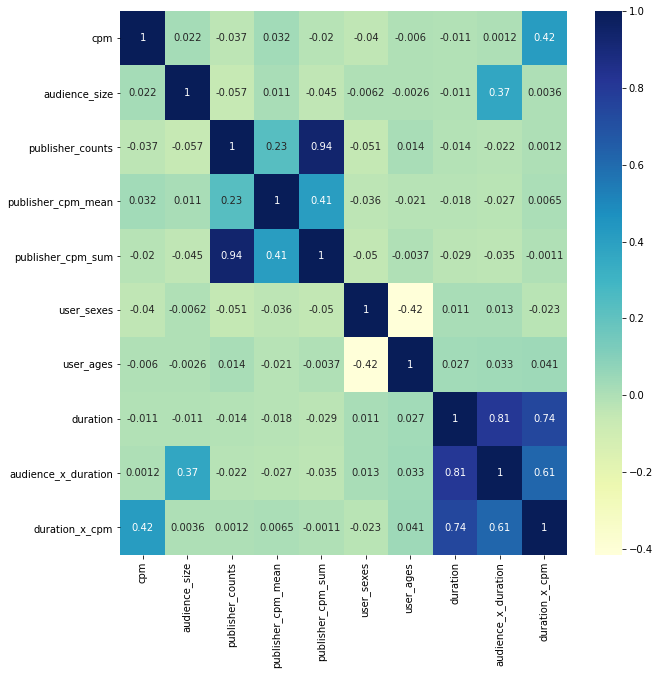

In [4]:
draw_corr_matrix(X, size=10)

Заметна очень сильная корелляция около значений для платформ, давайте попробуем отобрать из них меньше признаков:

1) Количество и сумма cpm очень сильно кореллируют, одно из них точно надо выбросить;
2) cpm_sum это довольно непонятное значение, которое непонятно как интерпретировать.

Выбросим cpm_sum.

In [5]:
X.drop('publisher_cpm_sum', axis=1, inplace=True)

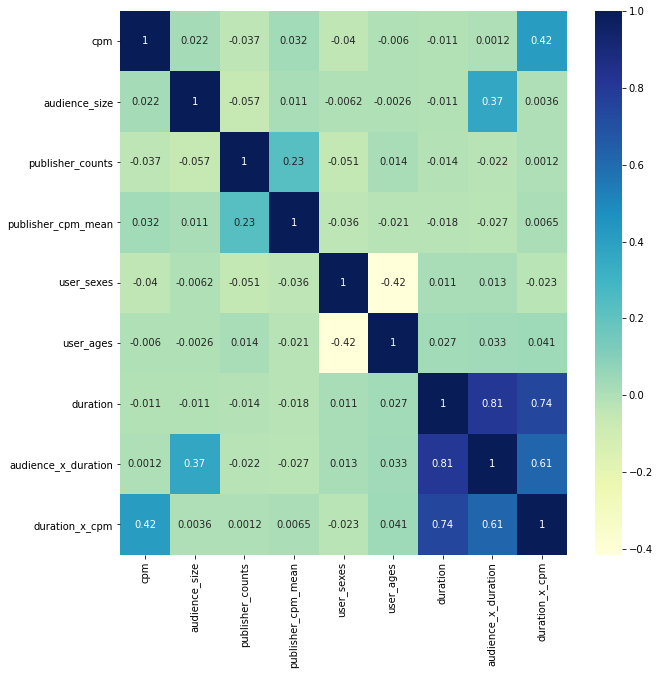

In [6]:
draw_corr_matrix(X, size=10)

Запустим линейную регрессию с L1-регуляризацией, чтобы выкинуть ненужные признаки:

In [7]:
from sklearn.preprocessing import StandardScaler as SScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

lasso = Pipeline([
    ('Scaler', SScaler()),
    ('Lasso', Lasso(alpha=0.01, random_state=42))
])

lasso.fit(X, y)

for (name, coef) in zip(X.columns, lasso['Lasso'].coef_):
    print('%s : %f' % (name.ljust(20), coef))

cpm                  : 0.005613
audience_size        : 0.000000
publisher_counts     : 0.055254
publisher_cpm_mean   : 0.003243
user_sexes           : 0.000000
user_ages            : -0.007268
duration             : 0.039452
audience_x_duration  : 0.000000
duration_x_cpm       : 0.035000


Ну что же, попробуем выкинуть те признаки, которые нам предлагает выкинуть лассо:

In [8]:
X.drop(['audience_size', 'user_sexes', 'audience_x_duration'], axis=1, inplace=True)

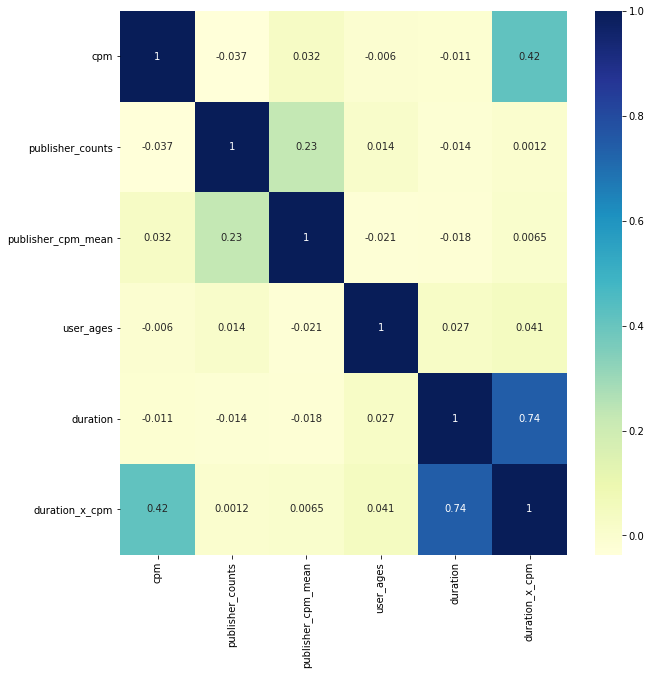

In [9]:
draw_corr_matrix(X, size=10)

## Хелперы

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def present_error(pred: np.ndarray, true: np.ndarray):
    mse = mean_squared_error(pred, true)
    mape = mean_absolute_percentage_error(pred, true)
    
    print('>> Mean Squared Error:             %.4f\n'
          '>> Mean Absolute Percentage Error: %.4f' % (mse, mape))
    
def test_model(model, name: str):
    print('==>> %s model <<==' % name)
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    print('>> Scores on train')
    present_error(pred_train, y_train)
    
    pred_test = model.predict(X_test)
    print('>> Scores on test')
    present_error(pred_test, y_test)

Мы будем решать задачу регрессии, так что инструментов попробуем много. Начнём с самого базового - линейной регрессии:

## Линейная регрессия

In [11]:
from sklearn.linear_model import LinearRegression as LinReg

linreg_model = LinReg(n_jobs=4)

test_model(linreg_model, 'Linear Regression')

==>> Linear Regression model <<==
>> Scores on train
>> Mean Squared Error:             0.0091
>> Mean Absolute Percentage Error: 1.1188
>> Scores on test
>> Mean Squared Error:             0.0111
>> Mean Absolute Percentage Error: 1.1231


Но что же это такое? Мы забыли нормализацию!

In [12]:
linreg_scaled_model = Pipeline([
    ('scaler', SScaler()),
    ('regressor', LinReg(n_jobs=4))
])

test_model(linreg_scaled_model, 'Linear Regression With Scaling')

==>> Linear Regression With Scaling model <<==
>> Scores on train
>> Mean Squared Error:             0.0091
>> Mean Absolute Percentage Error: 1.1188
>> Scores on test
>> Mean Squared Error:             0.0111
>> Mean Absolute Percentage Error: 1.1231


Ошибки получаются те же самые, а, логично.

## Catboost

In [20]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(
    iterations = 500,
    learning_rate = 0.01,
    depth = 2,
    verbose = False,
    random_state = 42
)

test_model(cb_model, 'CatBoost Regressor')

==>> CatBoost Regressor model <<==
>> Scores on train
>> Mean Squared Error:             0.0037
>> Mean Absolute Percentage Error: 0.5351
>> Scores on test
>> Mean Squared Error:             0.0069
>> Mean Absolute Percentage Error: 0.5885


Тут бы, конечно, погридсёрчить, но у меня времени мало.

## MLPRegressor

In [23]:
from sklearn.neural_network import MLPRegressor

mlp_model = Pipeline([
    ('scaler', SScaler()),
    ('regressor', MLPRegressor(random_state=42))
])

test_model(mlp_model, 'MLP Regressor')

==>> MLP Regressor model <<==
>> Scores on train
>> Mean Squared Error:             0.0068
>> Mean Absolute Percentage Error: 39.2521
>> Scores on test
>> Mean Squared Error:             0.0130
>> Mean Absolute Percentage Error: 1.5146


## SGDRegressor

In [24]:
from sklearn.linear_model import SGDRegressor

sgd_model = Pipeline([
    ('scaler', SScaler()),
    ('regressor', SGDRegressor(random_state=42))
])

test_model(sgd_model, 'SGD Regressor')

==>> SGD Regressor model <<==
>> Scores on train
>> Mean Squared Error:             0.0092
>> Mean Absolute Percentage Error: 1.2286
>> Scores on test
>> Mean Squared Error:             0.0111
>> Mean Absolute Percentage Error: 0.9181


## Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor as Forest

forest_model = Pipeline([
    ('scaler', SScaler()),
    ('regressor', Forest(n_estimators=400, max_depth=10, n_jobs=4, random_state=42))
])

test_model(forest_model, 'Random Forest')

==>> Random Forest model <<==
>> Scores on train
>> Mean Squared Error:             0.0006
>> Mean Absolute Percentage Error: 0.2187
>> Scores on test
>> Mean Squared Error:             0.0066
>> Mean Absolute Percentage Error: 0.5004


## Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

gbr_model = Pipeline([
    ('scaler', SScaler()),
    ('regressor', GBR(
        n_estimators = 500,
        learning_rate = 0.01,
        max_depth = 5,
        random_state = 42
    ))
])

test_model(gbr_model, 'Gradient Boosting Regressor')

==>> Gradient Boosting Regressor model <<==
>> Scores on train
>> Mean Squared Error:             0.0001
>> Mean Absolute Percentage Error: 0.2141
>> Scores on test
>> Mean Squared Error:             0.0064
>> Mean Absolute Percentage Error: 0.5266


## Сохранение модели

In [55]:
best_model = cb_model

In [56]:
from pickle import dump

best_model.fit(X, y)

with open('model/best_model.pickle', 'wb') as pickled:
    dump(best_model, pickled)

That's all, folks!